In [43]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import os
import glob

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
import corner

from agnfinder.tf_sampling import deep_emulator

In [45]:
os.chdir('/home/mike/repos/agnfinder')
# sotiria, change this to repo loc

In [46]:
# scp -r -oProxyJump=mikewalmsley@aquila.star.bris.ac.uk mike@zeus.star.bris.ac.uk:/scratch/agnfinder/agnfinder/results/vanilla_nested /media/mike/beta/agnfinder_results/vanilla_nested

In [47]:
save_dir = '/media/mike/beta/agnfinder_results/vanilla_mcmc'  # real galaxies, no emulator
# save_dir = '/media/mike/beta/agnfinder_results/vanilla_nested'  # real galaxies, no emulator
# save_dir = '/media/mike/beta/agnfinder_results/extended_nested_emulated_10'  # simulated galaxies, emulator
# save_dir = '/media/mike/beta/agnfinder_results/extended_nested_emulated_real_2'  # real galaxies, emulator

galaxy_locs = glob.glob(save_dir + '/*samples.h5py')
# galaxy_locs = glob.glob(save_dir + '/*.h5')
assert galaxy_locs

# open one galaxy for params
with h5py.File(galaxy_locs[0], mode='r') as f:
    params = f['samples'].attrs['free_param_names']

galaxies = []
true_observations = len(galaxy_locs)
for n, galaxy_loc in enumerate(galaxy_locs):
    try:
        with h5py.File(galaxy_loc, mode='r') as f:
            samples = np.squeeze(f['samples'][...])
#             sample_weights = np.squeeze(f['sample_weights'][...])
#             valid_data = samples.max(axis=1) > 0
#             samples = samples[valid_data]
#             sample_weights = sample_weights[valid_data]
#             normalised_weights = 10 ** sample_weights / (10 ** sample_weights).max()
            galaxies.append({
#                 'redshift': f['fixed_params'][...],
                'samples': samples,
                'sample_weights': np.ones(len(samples))/len(samples),
#                 'sample_weights': normalised_weights,
#                 'log_evidence': f['log_evidence'][-1],  # only care about the last one, value at convergence. Care about error also, eventually.
                'true_observations': np.squeeze(f['true_observations'][...]),
                'uncertainty': f['uncertainty'][...],
                'name': n,
                'sampled_photometry': f['sampled_photometry'][...]
            })
    except OSError:
        pass
    
n_samples = galaxies[0]['samples'].shape[0]
# samples = np.stack(sample_list, axis=1)

In [48]:
len(galaxies)

16

In [49]:
wavelengths = np.array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 21392.23213854,
       10205.12640526,  8801.6644194 , 33461.019081  , 45952.08900757])

In [50]:
def plot_galaxy(galaxy, ax, wavelengths):
    true_photometry = galaxy['true_observations']
    sample_indices = np.random.choice(np.arange(len(galaxy['sampled_photometry'])), 50, p=galaxy['sample_weights'])
    input_params = galaxy['samples']
    sample_photometry = galaxy['sampled_photometry'][sample_indices]

    ax.errorbar(wavelengths, true_photometry, label=r'true observation $\pm 2\sigma$', marker='+', linestyle='', yerr=galaxy['uncertainty']*2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(true_photometry.min() * .1, true_photometry.max() * 10)
    for trace in sample_photometry:
        ax.scatter(wavelengths, trace, color='r', marker='+', alpha=0.05)
    ax.legend()
    ax.set_title('{} {}'.format('passive', galaxy['name']))
    ax.set_ylabel('Maggies')
    ax.set_xlabel('Wavelength (A)')

In [51]:
def plot_galaxy_with_emulator(galaxy, ax, emulator, wavelengths):
    true_photometry = galaxy['true_observations']
    if 'redshift' not in params:
        redshifts = np.array([galaxy['redshift'] for _ in range(len(galaxy['samples']))])
    #     print(redshifts.shape)
    #     print(galaxy['samples'].shape)
        input_params = np.concatenate((redshifts, galaxy['samples']), axis=1)
    #     print(params_with_redshift.shape)
    else:
        input_params = galaxy['samples']
        
    sample_indices = np.random.choice(np.arange(len(galaxy['samples'])), 50, p=galaxy['sample_weights']/galaxy['sample_weights'].sum())
    sample_photometry = deep_emulator.denormalise_photometry(emulator(input_params[sample_indices])).numpy()
    np.random.shuffle(sample_photometry)

    ax.errorbar(wavelengths, true_photometry, label=r'true observation $\pm 2\sigma$', marker='+', linestyle='', yerr=galaxy['uncertainty']*2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    for trace in sample_photometry:
        ax.scatter(wavelengths, trace, color='r', marker='+', alpha=0.02)
    ax.legend()
#     ax.set_title('{} {}'.format(galaxy['rf_class'], galaxy['name']))
    ax.set_ylabel('Maggies')
    ax.set_xlabel('Wavelength (A)')

In [52]:
checkpoint_loc = 'results/checkpoints/latest'
emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_loc, new=False)

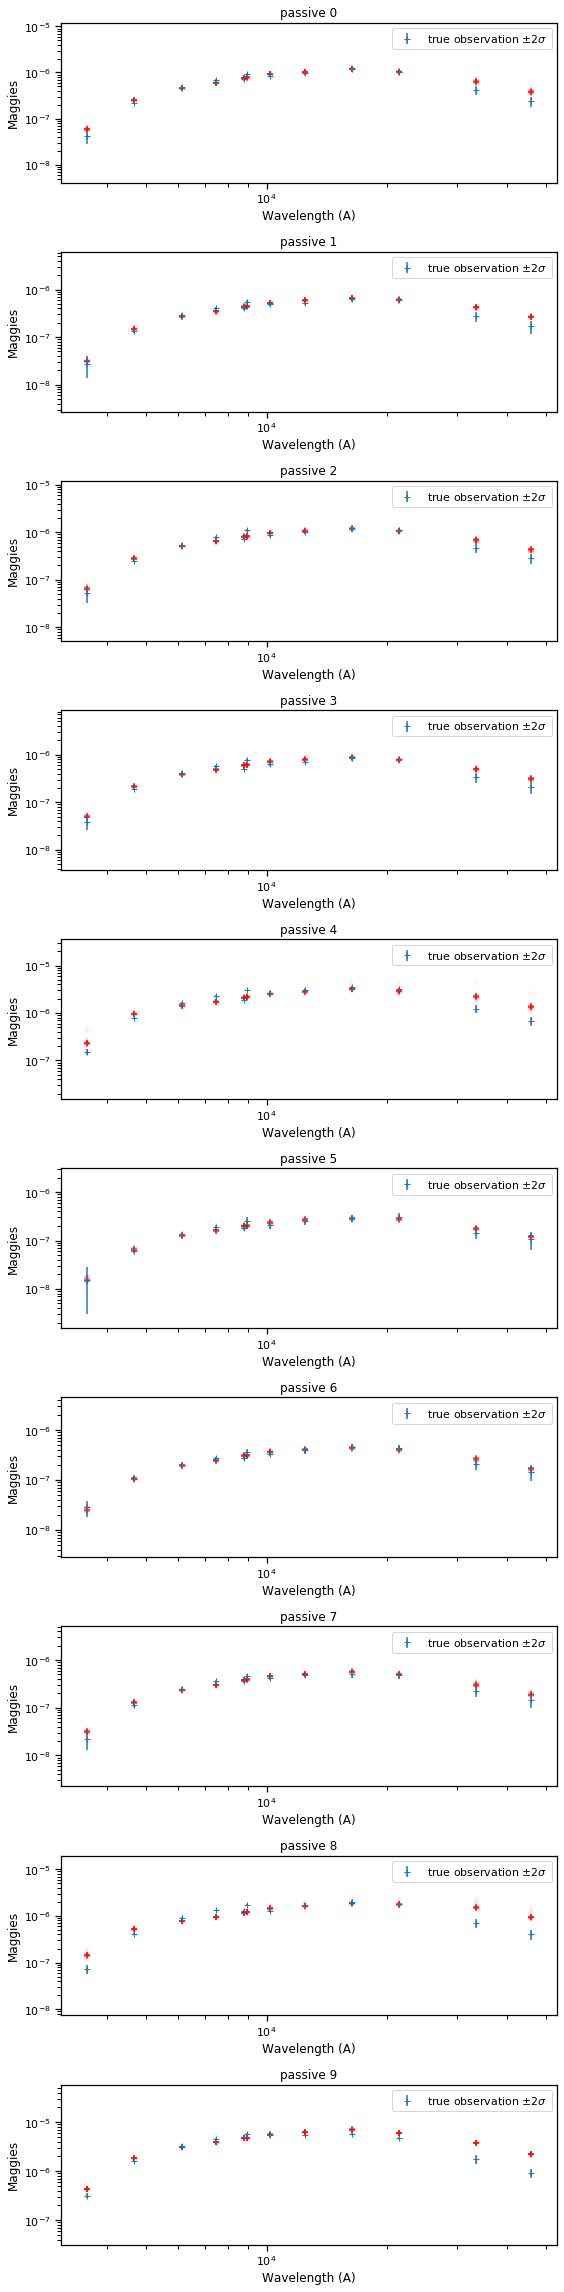

In [53]:
n_galaxies = 10

fig, axes = plt.subplots(nrows=n_galaxies, figsize=(8, 32))

n = 0
for galaxy in galaxies:
    ax = axes[n]
    plot_galaxy(galaxy, ax, wavelengths)
#     plot_galaxy_with_emulator(galaxy, ax, emulator, wavelengths)
    n += 1
    if n >= n_galaxies:
        break
plt.tight_layout()

In [54]:
galaxy = galaxies[0]
list(zip(galaxy['true_observations'], galaxy['uncertainty']))

[(4.0816059067742865e-08, 6.4162026623759e-09),
 (2.2108997866499538e-07, 4.77723646374588e-09),
 (4.774885550510071e-07, 7.711220295709458e-09),
 (6.849762632657291e-07, 1.0954062077083039e-08),
 (9.049404259279673e-07, 2.6494088902807715e-08),
 (1.2025721703679348e-06, 3.8476651066678644e-08),
 (9.892680039245183e-07, 3.180911052011001e-08),
 (1.0167805689099948e-06, 4.598079458740484e-08),
 (8.33939598120972e-07, 2.7365848751641923e-08),
 (7.225671653751645e-07, 1.5371128340583445e-08),
 (4.2120788086703503e-07, 4.8303656782513935e-08),
 (2.3766782729334576e-07, 3.161636143661255e-08)]

In [55]:
galaxy = galaxies[1]
list(zip(galaxy['true_observations'], galaxy['uncertainty']))

[(2.713505288102311e-08, 6.693360785183144e-09),
 (1.3216484827150262e-07, 3.80673455102638e-09),
 (2.8655059713709983e-07, 6.329598141746002e-09),
 (4.0613066177806796e-07, 8.9534753866549e-09),
 (5.459091926762188e-07, 2.8284935454342164e-08),
 (6.207726561833179e-07, 3.589520830266333e-08),
 (5.323653082744499e-07, 2.562523532309193e-08),
 (6.13125881614286e-07, 3.8284919382262626e-08),
 (4.873153055973742e-07, 1.9247442314884993e-08),
 (4.0198578974042494e-07, 1.0236600037960454e-08),
 (2.7462316830942395e-07, 3.275322258424023e-08),
 (1.7015171204451663e-07, 2.653742442160719e-08)]

[(2.5431337e-09, 1.9050541e-09),
 (5.1846416e-09, 8.36617e-10),
 (6.18054e-09, 1.0979665e-09),
 (5.235983e-09, 1.5432128e-09),
 (6.7476322e-09, 5.7406218e-09),
 (5.0192304e-09, 1.01911315e-08),
 (5.682986e-09, 5.6892597e-09),
 (7.1145743e-09, 1.1302889e-08),
 (6.990594e-09, 5.652528e-09),
 (6.381609e-09, 2.6232396e-09),
 (9.344009e-09, 7.629512e-09),
 (1.2561337e-08, 1.5730482e-08)]



In [56]:
10 ** galaxy['sample_weights']

array([1.00007027, 1.00007027, 1.00007027, ..., 1.00007027, 1.00007027,
       1.00007027])

(array([    0.,     0.,     0.,     0.,     0., 32768.,     0.,     0.,
            0.,     0.]),
 array([0.50007027, 0.60007027, 0.70007027, 0.80007027, 0.90007027,
        1.00007027, 1.10007027, 1.20007027, 1.30007027, 1.40007027,
        1.50007027]),
 <a list of 10 Patch objects>)

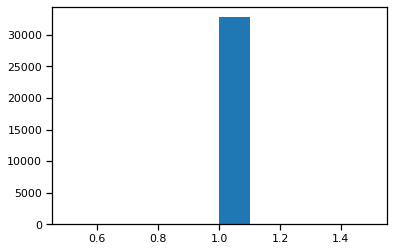

In [57]:
plt.hist(10 ** galaxy['sample_weights'])

In [58]:
plt.hist(normalised_weights)

NameError: name 'normalised_weights' is not defined

In [ ]:
_ = corner.corner(galaxy['samples'], weights=galaxy['sample_weights'], labels=params)